# Cal-CRAI Metric Calculation for: Governance / Protected Areas
This notebook calculates one metric sourced from the California Protected Areas Database

* Percentage of each California tract under management practices

In [1]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/governance/natural_resource_conservation/cal_protected_areas/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'governance_cnra_protected_areas.gpkg' locally


In [3]:
protected_areas_data = gpd.read_file('governance_cnra_protected_areas.gpkg')

In [4]:
protected_areas_data.columns

Index(['HOLDING_ID', 'ACCESS_TYP', 'UNIT_ID', 'UNIT_NAME', 'SUID_NMA',
       'AGNCY_ID', 'AGNCY_NAME', 'AGNCY_LEV', 'AGNCY_TYP', 'AGNCY_WEB',
       'LAYER', 'MNG_AG_ID', 'MNG_AGNCY', 'MNG_AG_LEV', 'MNG_AG_TYP',
       'SITE_NAME', 'ALT_SITE_N', 'PARK_URL', 'LAND_WATER', 'SPEC_USE', 'CITY',
       'COUNTY', 'ACRES', 'LABEL_NAME', 'DATE_REVIS', 'SRC_ATTR', 'SRC_ALIGN',
       'YR_PROTECT', 'YR_EST', 'GAP1_acres', 'GAP2_acres', 'GAP3_acres',
       'GAP4_acres', 'GAP_tot_ac', 'GAP_Source', 'USCB_STATEFP',
       'USCB_COUNTYFP', 'USCB_TRACTCE', 'USCB_GEOID', 'USCB_NAME',
       'USCB_NAMELSAD', 'USCB_MTFCC', 'USCB_FUNCSTAT', 'USCB_ALAND',
       'USCB_AWATER', 'USCB_INTPTLAT', 'USCB_INTPTLON', 'geometry'],
      dtype='object')

In [5]:
protected_areas_data.head()

,HOLDING_ID,ACCESS_TYP,UNIT_ID,UNIT_NAME,SUID_NMA,AGNCY_ID,AGNCY_NAME,AGNCY_LEV,AGNCY_TYP,AGNCY_WEB,...,USCB_GEOID,USCB_NAME,USCB_NAMELSAD,USCB_MTFCC,USCB_FUNCSTAT,USCB_ALAND,USCB_AWATER,USCB_INTPTLAT,USCB_INTPTLON,geometry
0,3,No Public Access,35058,El Corte de Madera Creek Open Space Preserve,28198,2079,Midpeninsula Regional Open Space District,Special District,Recreation/Parks District,http://www.openspace.org,...,06081613800,6138,Census Tract 6138,G5020,S,467817425,17465118,+37.2827241,-122.3443974,"POLYGON ((-122.34611 37.40300, -122.34619 37.4..."
1,6731,Open Access,18695,Pigeon Point Light Station State Historic Park,1679,204,California Department of Parks and Recreation,State,State Agency,http://www.parks.ca.gov/,...,06081613800,6138,Census Tract 6138,G5020,S,467817425,17465118,+37.2827241,-122.3443974,"POLYGON ((-122.39064 37.18311, -122.39073 37.1..."
2,6738,Open Access,18849,Portola Redwoods State Park,1696,204,California Department of Parks and Recreation,State,State Agency,http://www.parks.ca.gov/,...,06081613800,6138,Census Tract 6138,G5020,S,467817425,17465118,+37.2827241,-122.3443974,"POLYGON ((-122.19287 37.27233, -122.19278 37.2..."
3,6740,Restricted Access,18614,Pescadero Marsh Natural Preserve,23620,204,California Department of Parks and Recreation,State,State Agency,http://www.parks.ca.gov/,...,06081613800,6138,Census Tract 6138,G5020,S,467817425,17465118,+37.2827241,-122.3443974,"POLYGON ((-122.40759 37.26151, -122.40757 37.2..."
4,6743,Open Access,8566,Año Nuevo State Park,27967,204,California Department of Parks and Recreation,State,State Agency,http://www.parks.ca.gov/,...,06081613800,6138,Census Tract 6138,G5020,S,467817425,17465118,+37.2827241,-122.3443974,"POLYGON ((-122.32765 37.14373, -122.32883 37.1..."


<Axes: >

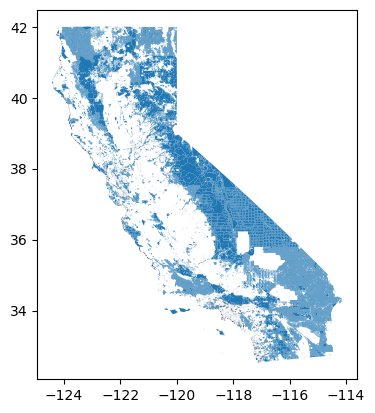

In [6]:
protected_areas_data.plot()

In [7]:
# selecting relevant columns for processing
selected_columns = ['HOLDING_ID', 'ACCESS_TYP', 'UNIT_ID', 'UNIT_NAME', 'AGNCY_NAME',
       'SITE_NAME', 'COUNTY', 'ACRES', 'SRC_ATTR', 'SRC_ALIGN', 'GAP1_acres', 'GAP2_acres', 'GAP3_acres',
       'GAP4_acres', 'GAP_tot_ac',
       'USCB_COUNTYFP', 'USCB_TRACTCE', 'USCB_GEOID', 'geometry']

filtered_protected_areas_data = protected_areas_data[selected_columns]
filtered_protected_areas_data

,HOLDING_ID,ACCESS_TYP,UNIT_ID,UNIT_NAME,AGNCY_NAME,SITE_NAME,COUNTY,ACRES,SRC_ATTR,SRC_ALIGN,YR_PROTECT,GAP1_acres,GAP2_acres,GAP3_acres,GAP4_acres,GAP_tot_ac,USCB_COUNTYFP,USCB_TRACTCE,USCB_GEOID,geometry
0,3,No Public Access,35058,El Corte de Madera Creek Open Space Preserve,Midpeninsula Regional Open Space District,El Corte de Madera Creek Open Space Preserve,San Mateo,1.752467,AGENCY,PARCELS,2019.0,0.0,1.0,0.0,0.0,1.0,081,613800,06081613800,"POLYGON ((-122.34611 37.40300, -122.34619 37.4..."
1,6731,Open Access,18695,Pigeon Point Light Station State Historic Park,California Department of Parks and Recreation,Pigeon Point Light Station State Historic Park,San Mateo,11.425018,None,None,1981.0,0.0,0.0,9.0,1.0,10.0,081,613800,06081613800,"POLYGON ((-122.39064 37.18311, -122.39073 37.1..."
2,6738,Open Access,18849,Portola Redwoods State Park,California Department of Parks and Recreation,Portola Redwoods State Park,San Mateo,79.441035,None,PARCELS,1945.0,0.0,79.0,0.0,0.0,79.0,081,613800,06081613800,"POLYGON ((-122.19287 37.27233, -122.19278 37.2..."
3,6740,Restricted Access,18614,Pescadero Marsh Natural Preserve,California Department of Parks and Recreation,Pescadero Marsh State Beach,San Mateo,68.193241,None,WATER,1974.0,0.0,68.0,0.0,0.0,68.0,081,613800,06081613800,"POLYGON ((-122.40759 37.26151, -122.40757 37.2..."
4,6743,Open Access,8566,Año Nuevo State Park,California Department of Parks and Recreation,Año Nuevo State Park,San Mateo,15.100543,None,None,NaN,0.0,15.0,0.0,0.0,15.0,081,613800,06081613800,"POLYGON ((-122.32765 37.14373, -122.32883 37.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138791,75555,Restricted Access,50378,HOA Park - Orange County,Home Owners Association - Orange County,Princeton Park,Orange,2.811817,AGENCY,PARCELS,NaN,0.0,0.0,0.0,2.0,2.0,059,062626,06059062626,"POLYGON ((-117.84283 33.65609, -117.84263 33.6..."
138792,75321,Restricted Access,50378,HOA Park - Orange County,Home Owners Association - Orange County,HOA Community Park,Orange,9.442193,None,PARCELS,NaN,0.0,0.0,0.0,9.0,9.0,059,032035,06059032035,"POLYGON ((-117.63956 33.63095, -117.63952 33.6..."
138793,75322,Restricted Access,50378,HOA Park - Orange County,Home Owners Association - Orange County,Gallup Park,Orange,4.624968,AGENCY,PARCELS,NaN,0.0,0.0,0.0,4.0,4.0,059,042328,06059042328,"POLYGON ((-117.68586 33.58639, -117.68541 33.5..."
138794,75378,Restricted Access,50378,HOA Park - Orange County,Home Owners Association - Orange County,Dapple Grey Park,Orange,6.635482,AGENCY,PARCELS,NaN,0.0,0.0,0.0,6.0,6.0,059,042328,06059042328,"POLYGON ((-117.68757 33.57526, -117.68776 33.5..."


In [8]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1', 'geometry'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)

C:\Users\jesse\AppData\Local\Temp\ipykernel_3992\4083292558.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)


In [9]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries[['GEOID', 'geometry']]
ca_boundaries = ca_boundaries.rename(columns={'GEOID':'tract'})

In [10]:
ca_tract_county_spatial = pd.merge(ca_tract_county, ca_boundaries, on='tract', how='left')
ca_tract_county_spatial = ca_tract_county_spatial.rename(columns={'tract':'USCB_GEOID'})
ca_tract_county_spatial

,USCB_GEOID,countyfp,county,geometry
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


In [11]:
geo_ca_tract_county = gpd.GeoDataFrame(ca_tract_county_spatial)

In [14]:
# Step 1: Check the CRS
print("Initial CRS of protected areas:", filtered_protected_areas_data.crs)
print("Initial CRS of CA tract/counties dataset:", geo_ca_tract_county.crs)

# Step 2: Reproject to an appropriate CRS for area calculations
gdf1 = filtered_protected_areas_data.to_crs(epsg=3310)  # California Albers
gdf2 = geo_ca_tract_county.to_crs(epsg=3310)  # California Albers

print("Reprojected CRS of cnra protected areas:", gdf1.crs)
print("Reprojected CRS of Counties:", gdf2.crs)

# Check for and fix invalid geometries in both GeoDataFrames
gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

# Verify if all geometries are now valid
print("Protected areas geometries valid:", gdf1.is_valid.all())
print("County geometries valid:", gdf2.is_valid.all())

# Step 3: Calculate the total area of protected areas per tract
protected_area_tract = gdf1.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='protected_tract_area')

# Step 4: Calculate the total area of each county
county_area = gdf2.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='tract_area')

# Step 5: Merge the two datasets on the county column
merged_df = pd.merge(protected_area_tract, county_area, on='USCB_GEOID')

# Step 6: Calculate the spatial percentage of NTMPs per county
merged_df['protected_areas_percentage'] = (merged_df['protected_tract_area'] / merged_df['tract_area']) * 100

Initial CRS of protected areas: EPSG:4269
Initial CRS of CA tract/counties dataset: EPSG:4269
Reprojected CRS of cnra protected areas: EPSG:3310
Reprojected CRS of Counties: EPSG:3310
Protected areas geometries valid: True
County geometries valid: True


In [15]:
merged_df

,USCB_GEOID,protected_tract_area,tract_area,protected_areas_percentage
0,06001400100,1.202579e+06,6.945851e+06,17.313634
1,06001400300,4.206150e+03,1.110836e+06,0.378647
2,06001400400,1.488980e+03,7.161367e+05,0.207918
3,06001400500,3.134222e+04,5.914232e+05,5.299457
4,06001400700,5.882607e+03,8.657521e+05,0.679479
...,...,...,...,...
6810,06115040902,1.182862e+03,9.384312e+07,0.001260
6811,06115041001,3.482645e+05,2.776416e+08,0.125437
6812,06115041002,5.443862e+07,1.976832e+08,27.538314
6813,06115041101,2.098810e+08,4.814353e+08,43.594855


In [16]:
print(merged_df.protected_areas_percentage.max())
print(merged_df.protected_areas_percentage.min())

99.11175171340344
6.682832475318667e-21


In [17]:
# merge back to CA tract/county data so we have our 9129 census tracts
protected_areas_metric = pd.merge(ca_tract_county_spatial, merged_df, on='USCB_GEOID', how='left')
protected_areas_metric

,USCB_GEOID,countyfp,county,geometry,protected_tract_area,tract_area,protected_areas_percentage
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3...",NaN,NaN,NaN
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4...",1.509451e+04,1.102135e+06,1.369569
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2...",3.291201e+06,9.529867e+06,34.535639
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2...",2.364880e+04,2.424455e+06,0.975427
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3...",7.919443e+03,3.311439e+05,2.391541
...,...,...,...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9...",7.869566e+04,1.179647e+06,6.671122
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9...",9.323200e+03,1.252715e+06,0.744240
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9...",1.650788e+04,1.608852e+06,1.026066
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9...",1.176966e+04,1.322255e+06,0.890120


In [18]:
protected_areas_metric.to_csv('governance_cnra_protected_areas_metric.csv')

## Function Call

In [21]:
@append_metadata
def timber_management_upload(input_csv, export=False, varname=''):
    '''
    Uploads the protected areas metric to S3 bucket. The metric is:
    
    * % of tract under management practices

    Data for this metric was sourced from theCalifornia Natural Resources Agency: California Protected Areas Database at
    https://data.cnra.ca.gov/dataset/california-protected-areas-database/resource/27323846-4000-42a2-85b3-93ae40edeff9

    Methods
    -------
    Relevant data columns were isolated, some were renamed for later merging with California tract data.
    Data was reprojected to match California tract data.
    Using both datasets 'geometry' columns, a total area column for each tract entry was calculated.
    Estimated tract percentage under management practices was calculated by dividing estimated tract land under management
    by estimated total tract area.
    
    Parameters
    ----------
    input_csv: string
        csv protected areas metric data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI protected areas metric to AWS
        True = will upload resulting df containing CAL CRAI protected areas metric to AWS

    Script
    ------
    governance_protected_areas.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: relevant columns were isolated and renamed')
    print('Data transformation: data reprojected to epsg 3310')
    print('Data transformation: a new column was created to estimate percentage of each tract with management practices')

    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    '''if os.path.exists(input_csv):
        os.remove(input_csv)'''

In [22]:
input_csv = 'governance_cnra_protected_areas_metric.csv'
variable = 'governance_cnra_protected_areas'

timber_management_upload(input_csv, varname='test', export=False)